In [1]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

# Data Reading and Exploration

In [2]:
df = pd.read_csv('dataset.csv')
df.columns = ['id', 'date', 'cons']
df.head()

id        date    cons
0  255813.0  2020-02-22  11.070
1   97302.0  2020-10-10   0.455
2  260283.0  2020-10-15   2.790
3    6564.0  2019-03-01   0.002
4    6547.0  2019-07-08   0.461

Frist, we see that the dataset is not chronologically ordered. And we will need to handle this later on.

In [3]:
# lets check out the null values
df.isnull().sum().rename('count').to_frame()

count
id        1
date     14
cons     11

There is one null value in the OID column. It is preferred to drop the whole row than relating it to a rondom customer.

We will also drop all the rows where the date is unknown. It is pretty much hard to figure out to which days these rows belong. This is because there are several days in which consumer records are not available. This can be due to zero consumption (we go for this) or a dropped reading.

For the Consumption feature will be imputing its null values to zero, assuming there is no consumption on that day.

Moreover, we will generate a new binary feature to indicate the rows with null values. This is a good stage so as to avoid using rows with imputed values in the test split.

In [4]:
# drop all the rows where the date is unknown
df.dropna(subset=['id', 'date'], axis=0, inplace=True)
df.id = df.id.astype(int)

# create a new feature to indicate rows with null values
df['is_null'] = np.sum(df.isnull(), axis=1)

# fill null values in the cons column
df.cons.fillna(0, inplace=True)

# now we will convert the date feature to a datetime feature to better handle it
df.date = pd.to_datetime(df.date)

In [5]:
# lets group by date and get some descriptive statistics
grouped_by_date = df.groupby('date')['date'].count().rename('count').to_frame()

grouped_by_date['count'].describe().rename('').to_frame()

count  840.000000
mean   213.300000
std     58.868638
min     97.000000
25%    160.000000
50%    246.500000
75%    266.000000
max    272.000000

In [6]:
# number of unique users
print(f'Number of unique users: {df.id.nunique()}')

Number of unique users: 272


We have 272 unique clients, however, not all timestamps have this number of clients. This can be potentially attributed to that those clients actually have zero consumption in those dates. Hence, the rows will be re-ordered and a consumption value of zero will given to each of those client on the corresponding dates.

But, before that let's see the distribution of the counts.

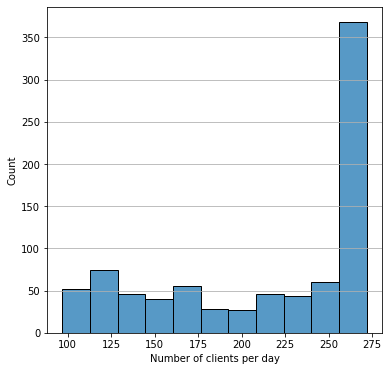

In [7]:
plt.figure(figsize=(6, 6))
sns.histplot(grouped_by_date.values.flatten())
plt.xlabel('Number of clients per day')
plt.grid(axis='y')
plt.show()

Because each client can have different consumption values, and hence, different consumption distribution, we need to figure out each client's distribution and define their own outlier thresholds.

In [8]:
warnings.filterwarnings('ignore')
grouped_by_ids = df.groupby('id')
plt.figure(figsize=(6*6, 6*91))

his_inc = list(range(1, len(grouped_by_ids)+2))
box_inc = list(range(2, len(grouped_by_ids)+2))

for i, group in tqdm(enumerate(grouped_by_ids), total=len(grouped_by_ids)):
    if i == 53: # takes long time, will be studied later
        continue
    plt.subplot(91, 6, i+his_inc[i])
    sns.histplot(group[1].cons.values)
    plt.title(group[0])
    plt.subplot(91, 6, i+box_inc[i])
    plt.title(group[0])
    sns.boxplot(group[1].cons.values, color='coral')
    
plt.show()

  0%|          | 0/272 [00:00<?, ?it/s]

Let's first group our data by id, re-oreder it, resample it to see its line plots. This will give us and indication of reasonability of the readings and whether the outliers are real values or just false readings that need to be imputed.

In [9]:
def resampling(group_df):
    '''
    Inputs:
        group_df: (DataFrame) containing the readings of a single client (id)
    Returns:
        mean_data, max_data: (series) cotaining the mean and max readings of the weekly resampled 
                             choronologically ordered data
    '''
    resampled = group_df.\
                drop(['id', 'is_null'], axis=1).\
                set_index('date', drop=True).\
                sort_index().\
                resample('W').\
                agg(['mean', 'max'])

    mean_data = resampled.iloc[:, 0]
    max_data  = resampled.iloc[:, 1]
    
    return mean_data, max_data, resampled

Let's define a global outlier threshold:

**<span style="color:blue">P is Outlier if:</span>**

$~~~~~~~~~~~~~~~~~~~~~~~P > (1.5 \times IQR) + Q_3$

And define local thresholds for each id using the same above eqn.

In [10]:
def compute_outlier(df):
    '''
    Inputs:
        df: (DataFrame)
    Returns:
        outlier_thresh: (float) outlier threshold value
    '''
    q_1 = np.percentile(df.cons, q=25)
    q_3 = np.percentile(df.cons, q=75)
    iqr = q_3 - q_1
    outlier_thresh = q_3 + (iqr * 1.5)
    return outlier_thresh

In [11]:
# global outlier threshold
global_thresh = compute_outlier(df)

# local thresholds
local_threshs = df.groupby('id').\
               apply(lambda x: compute_outlier(x)).\
               to_frame().\
               rename(columns={0: 'threshold'}).\
               reset_index(drop=False)

  0%|          | 0/272 [00:00<?, ?it/s]

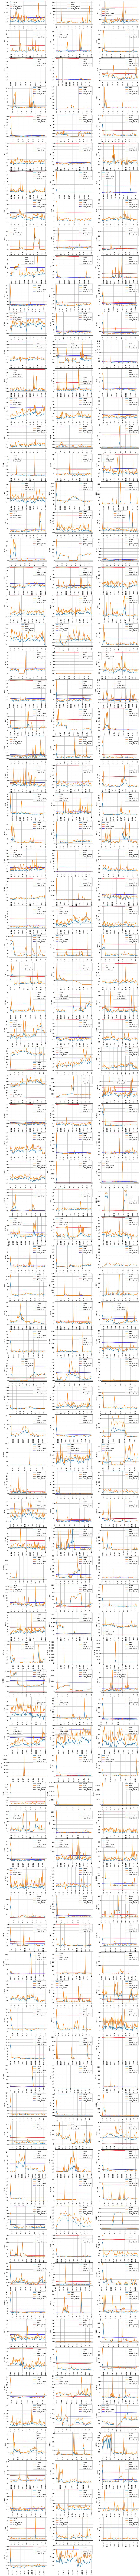

In [12]:
warnings.filterwarnings('ignore')
grouped_by_ids = df.groupby('id')
plt.figure(figsize=(6*3, 4*91))

for i, group in tqdm(enumerate(grouped_by_ids), total=len(grouped_by_ids)):
    plt.subplot(91, 3, i+1)
    mean_data, max_data, resampled_df = resampling(group[1])
    local_thresh = local_threshs[local_threshs['id']==group[0]]['threshold'].values[0]
    plt.plot(mean_data)
    plt.plot(max_data)
    plt.hlines(y=global_thresh, 
               xmin=resampled_df.index.min(), 
               xmax=resampled_df.index.max(), 
               linestyle='--', 
               color='red')
    plt.hlines(y=local_thresh, 
               xmin=resampled_df.index.min(), 
               xmax=resampled_df.index.max(), 
               linestyle='--', 
               color='blue')
    plt.legend(['mean', 'max', 'global_thresh', 'local_thresh'])
    plt.xticks(rotation=90)
    plt.ylabel(group[0])
    plt.grid()
    
plt.show()

It can be observed that a common pattern exist in multiple time-series. The pattern is that the series starts very high and then suddenly decreases to values close to their medians. see the series of the following ids:

[2809, 6507, 13537, 13636, 13964, 15898, 37309, 244391, 245028]

  0%|          | 0/272 [00:00<?, ?it/s]

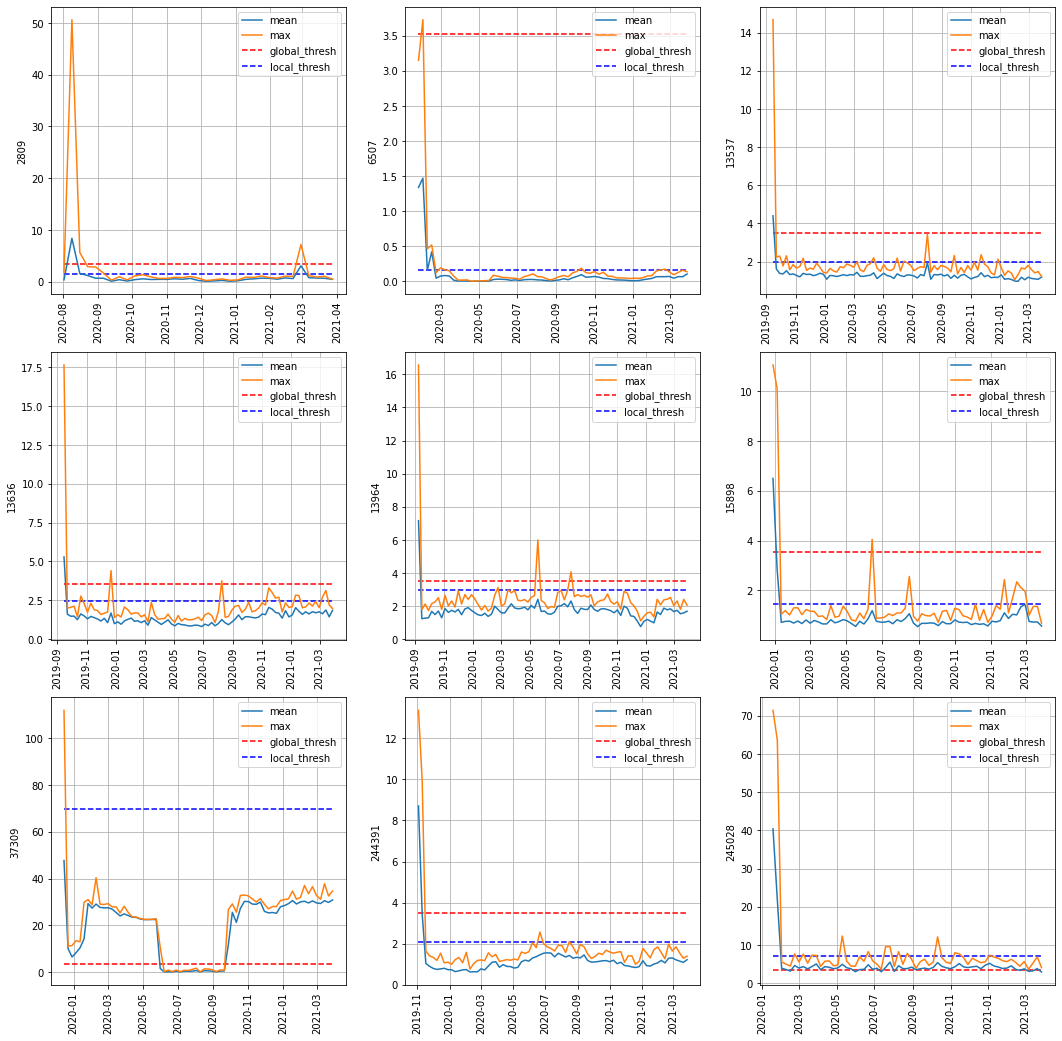

In [13]:
# exploring the pattern
warnings.filterwarnings('ignore')
grouped_by_ids = df.groupby('id')
plt.figure(figsize=(6*3, 6*3))

i = 1
for group in tqdm((grouped_by_ids), total=len(grouped_by_ids)):
    if group[0] in [2809, 6507, 13537, 13636, 13964, 15898, 37309, 244391, 245028]:
        plt.subplot(3, 3, i)
        mean_data, max_data, resampled_df = resampling(group[1])
        local_thresh = local_threshs[local_threshs['id']==group[0]]['threshold'].values[0]
        plt.plot(mean_data)
        plt.plot(max_data)
        plt.hlines(y=global_thresh, 
                   xmin=resampled_df.index.min(), 
                   xmax=resampled_df.index.max(), 
                   linestyle='--', 
                   color='red')
        plt.hlines(y=local_thresh, 
                   xmin=resampled_df.index.min(), 
                   xmax=resampled_df.index.max(), 
                   linestyle='--', 
                   color='blue')
        plt.legend(['mean', 'max', 'global_thresh', 'local_thresh'])
        plt.xticks(rotation=90)
        plt.ylabel(group[0])
        plt.grid()
        i += 1
    
plt.show()

Thus, it is not weird to see the peak value of id "32053" above 1200, as compared to distibution of its values.

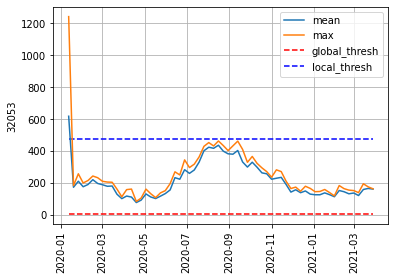

In [14]:
# check out id: 32053
id = 32053
plt.figure(figsize=(6, 4))
group = grouped_by_ids.get_group(id)
mean_data, max_data, resampled_df = resampling(group)
local_thresh = local_threshs[local_threshs['id']==id]['threshold'].values[0]
plt.plot(mean_data)
plt.plot(max_data)
plt.hlines(y=global_thresh, 
           xmin=resampled_df.index.min(), 
           xmax=resampled_df.index.max(), 
           linestyle='--', 
           color='red')
plt.hlines(y=local_thresh, 
           xmin=resampled_df.index.min(), 
           xmax=resampled_df.index.max(), 
           linestyle='--', 
           color='blue')
plt.legend(['mean', 'max', 'global_thresh', 'local_thresh'])
plt.xticks(rotation=90)
plt.ylabel(id)
plt.grid()
    
plt.show()

This may represent the consumption of a relatively huge entity. Hence, we cannot treat all the clients similarly by using the global outlier threshold. Using the local outlier threshold is more reliable and would eventually lead to more realistic predictions.

On the other hand, some values are apparently extremes and should be tackled somehow. Examples are the following indexes:

[107431, 250409, 249971, 250252]

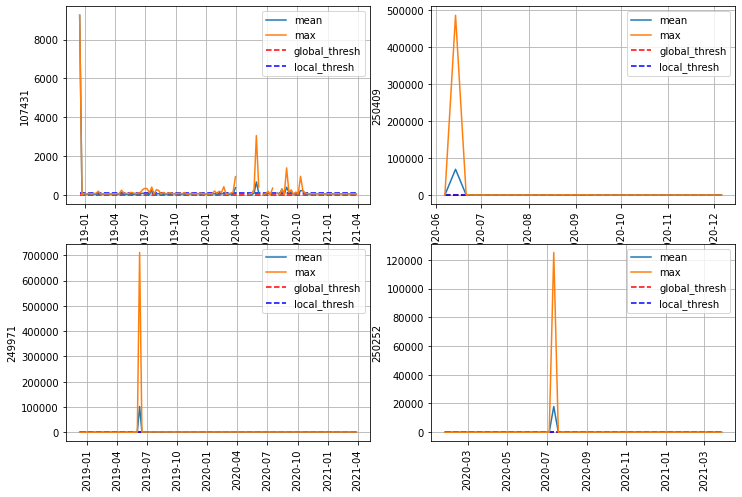

In [15]:
# check out ids: 107431
ids = [107431, 250409, 249971, 250252]
plt.figure(figsize=(6*2, 4*2))

for i, id in enumerate(ids):
    group = grouped_by_ids.get_group(id)
    mean_data, max_data, resampled_df = resampling(group)
    local_thresh = local_threshs[local_threshs['id']==id]['threshold'].values[0]
    plt.subplot(2, 2, i+1)
    plt.plot(mean_data)
    plt.plot(max_data)
    plt.hlines(y=global_thresh, 
               xmin=resampled_df.index.min(), 
               xmax=resampled_df.index.max(), 
               linestyle='--', 
               color='red')
    plt.hlines(y=local_thresh, 
               xmin=resampled_df.index.min(), 
               xmax=resampled_df.index.max(), 
               linestyle='--', 
               color='blue')
    plt.legend(['mean', 'max', 'global_thresh', 'local_thresh'])
    plt.xticks(rotation=90)
    plt.ylabel(id)
    plt.grid()
    
plt.show()

Having that said, we need to re-define the outlier thresholds using our data. For this purpose, we will see the how much the max value is far away from the previously defined threshold.

In [16]:
# check out id: 32053
# reasonable value
id = 32053
group = grouped_by_ids.get_group(id)
local_thresh = local_threshs[local_threshs['id']==id]['threshold'].values[0]
print(f'(Max - Threshold) / Threshold: {(group.cons.max() - local_thresh) / local_thresh}')

(Max - Threshold) / Threshold: 1.6155715648769595


In [17]:
# check out ids: [107431, 250409, 249971, 250252]
# unreasonable value
ids = [107431, 250409, 249971, 250252]
for id in ids:
    group = grouped_by_ids.get_group(id)
    local_thresh = local_threshs[local_threshs['id']==id]['threshold'].values[0]
    print(f'ID: {id} | (Max - Threshold) / Threshold: {(group.cons.max() - local_thresh) / local_thresh}')

ID: 107431 | (Max - Threshold) / Threshold: 98.93064283437168
ID: 250409 | (Max - Threshold) / Threshold: 2289.9814117647056
ID: 249971 | (Max - Threshold) / Threshold: 757.9740360240161
ID: 250252 | (Max - Threshold) / Threshold: 3354.7773306505705


We can safely define the outlier as values that have a difference ratio to the the threshold bigger than 10. 

These outliers will be clipped to the threshold values. This is safer in modeling in which there is a clear indication that the value is high + for as a factor of safety for the clients.

In [18]:
# create a new column for the thresholds by merging
df = df.merge(local_threshs, left_on='id', right_on='id', how='left')

# replace the null value in the threshold column with the value of the consumption
df.loc[df.index[df.threshold.isnull()], 'threshold'] = df.loc[df.index[df.threshold.isnull()], 'cons']

In [19]:
def detect_impute_outliers(row):
    prev_local_thresh = row.threshold
    to_compare = (row.cons - prev_local_thresh) / (prev_local_thresh + 1e-10) # 1e-10 to avoid division by zero
    if to_compare > 10:
        return prev_local_thresh
    return row.cons

In [20]:
# detect outliers
tqdm.pandas()
df['cons_with_outliers_imputed'] = df.progress_apply(detect_impute_outliers, axis=1)

  0%|          | 0/179172 [00:00<?, ?it/s]

In [21]:
template_df = pd.DataFrame(data=np.zeros((272, 1)), columns=['id'])
all_ids = np.sort(df.id.unique())
template_df.id = all_ids
columns = df.columns.tolist()

def pad_sequence(df):
    '''
    Inputs:
        df: (DataFrame)
    Returns:
        padded_df: (DataFrame) the sequences are padded to the same length (272): the number of unique ids
    '''
    padded_df = template_df.merge(df.drop(['date', 'threshold'], axis=1), left_on='id', right_on='id', how='left').\
              merge(local_threshs, left_on='id', right_on='id', how='left')
    padded_df.cons.fillna(0, inplace=True)
    padded_df.is_null.fillna(1, inplace=True)
    padded_df.cons_with_outliers_imputed.fillna(0, inplace=True)
    padded_df = padded_df.sort_values(by=['id'])
    padded_df['date'] = df.reset_index(drop=True).loc[0, 'date']
    padded_df = padded_df[columns]
    return padded_df

In [22]:
grouped_by_date = df.groupby('date')
padded_df = pd.DataFrame()

for group in tqdm(grouped_by_date):
    group_df = group[1]
    paddes_sequence = pad_sequence(group_df)
    padded_df = pd.concat([padded_df, paddes_sequence], axis=0)

padded_df.reset_index(drop=True, inplace=True)
padded_df.head()

  0%|          | 0/840 [00:00<?, ?it/s]

id       date   cons  is_null  threshold  cons_with_outliers_imputed
0   716 2018-12-06  0.000      1.0   1.167125                       0.000
1   798 2018-12-06  0.000      1.0   1.169375                       0.000
2   848 2018-12-06  0.000      1.0   1.031250                       0.000
3   865 2018-12-06  0.078      0.0   0.856625                       0.078
4  1004 2018-12-06  0.372      0.0   0.971875                       0.372

Now that we are done with data preprocessing, we can split our data set into training, validation, and test splits. We will use prior data for training, and the more recent data for both validation and testing.

In [23]:
unique_days = padded_df.date.unique()
print(f'Number of unique dates: {len(unique_days)}')

Number of unique dates: 840


In [24]:
# use 20 days for the validation set and 30 days for test set
train_days = unique_days[:-50]
valid_days = unique_days[-(50+365):-30] # 365 previous readings as inputs
test_days  = unique_days[-(30+365):]

train_df = padded_df[padded_df.date.isin(train_days)][['id', 'date', 'cons_with_outliers_imputed']].reset_index(drop=True)
valid_df = padded_df[padded_df.date.isin(valid_days)][['id', 'date', 'cons_with_outliers_imputed']].reset_index(drop=True)
test_df = padded_df[padded_df.date.isin(test_days)][['id', 'date', 'cons_with_outliers_imputed']].reset_index(drop=True)

In [25]:
print(f'Size of train data: {len(train_df)} rows.')
print(f'Size of valid data: {len(valid_df)} rows.')
print(f'Size of test data:  {len(test_df)} rows.')

Size of train data: 214880 rows.
Size of valid data: 104720 rows.
Size of test data:  107440 rows.


In [26]:
train_df.columns = ['id', 'date', 'cons']
valid_df.columns = ['id', 'date', 'cons']
test_df.columns = ['id', 'date', 'cons']

In [27]:
def construct_per_id_sequences(group_df):
    '''
    Inputs: 
        group_df: (DataFrame) dataframe grouped by id
    Returns:
        x, y: (lists) x: is a list of arrays, each array is of 365 length (these are the inputs to the models)
                      y: is a list of floats, each float is the next value of x (the targets to be predicted)
    '''
    x = []
    y = []
    for i in range(0, len(group_df)-365):
        x.append(group_df.cons.values[i:i+365])
        y.append(group_df.cons.values[i+365])
    return x, y

In [28]:
def construct_final_dataset(grouped_df):
    ids, X, Y = [], [], []
    for group in tqdm(grouped_df, total=len(grouped_df)):
        x, y = construct_per_id_sequences(group[1])
        ids.extend([group[0]] * len(x))
        X.extend(x)
        Y.extend(y)
    return np.c_[ids, np.stack(X), Y]

In [29]:
# construct sequences grouped by ids
train_groups = train_df.groupby('id')
valid_groups = valid_df.groupby('id')
test_groups = test_df.groupby('id')


    
train_np = construct_final_dataset(train_groups)
valid_np = construct_final_dataset(valid_groups)
test_np = construct_final_dataset(test_groups)

print(f'Train data shape: {train_np.shape}')
print(f'Valid data shape: {valid_np.shape}')
print(f'Test data shape : {test_np.shape}')

np.save('train_np.npy', train_np)
np.save('valid_np.npy', valid_np)
np.save('test_np.npy', test_np)

  0%|          | 0/272 [00:00<?, ?it/s]

  0%|          | 0/272 [00:00<?, ?it/s]

  0%|          | 0/272 [00:00<?, ?it/s]

Train data shape: (115600, 367)
Valid data shape: (5440, 367)
Test data shape : (8160, 367)
